In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns

# Load data

## for barcode, feature, matrix file.

In [2]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, genes 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [3]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"
adata_list = read_10x_mtx_multiple(folder_path)

adata_list
# 40s for 24 samples

C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319503_SF10099_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319503_SF10099_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319503_SF10099_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319504_SF10432_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319504_SF10432_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319504_SF10432_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319505_SF10857_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319505_SF10857_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319505_SF10857_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Sigl

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 994 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with 

## for .h5 file
> 작동 안할 확률 있음\
> 뒤의 코드와 안맞을 확률 있음

In [ ]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/13. aPD-1 Fcgr2b for scanpy test/aPD-1_analysis/"
adata_list = []

# Load all datas in the control folder
for filename in os.listdir(folder_path + 'control/'):
    file_path = os.path.join(folder_path + 'control/', filename)
    
    if filename.endswith(".h5"):                # Check if the file is a 10x data
        adata = sc.read_10x_h5(file_path)       # Read the 10x data
        adata.obs['sample_type'] = 'control'    # Add the sample type to the metadata
        adata.var_names_make_unique()           # Make the gene names unique
        adata_list.append(adata)                    # Append the data to the list

# load all datas in the treatment folder
for filename in os.listdir(folder_path + 'treated/'):
    file_path = os.path.join(folder_path + 'treated/', filename)
    
    if filename.endswith(".h5"):                # Check if the file is a 10x data
        adata = sc.read_10x_h5(file_path)       # Read the 10x data
        adata.obs['sample_type'] = 'treatment'      # Add the sample type to the metadata
        adata.var_names_make_unique()           # Make the gene names unique
        adata_list.append(adata)                    # Append the data to the list

# delete the variable to save memory
del file_path, filename, folder_path, adata



# Basic filtering

In [4]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 200)
adata_list

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 453 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332

# n_count_RNa, n_count_feature, pct_mt filtering

In [5]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [6]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [ ]:
adata_list[1].obs.head(5)

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [7]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [15]:
adata_list = [adata for adata in adata_list if adata.n_obs > 30]

# Doublet removal
> **scVI SOLO와 Scrublet 두 방식 <- 둘 중 하나만 쓰면 됨**

## By scVI SOLO
> (아마) 좋은거 같긴 한데 개느림\
> 아래 코드 돌아가는지도 잘 모르겠음. 돌리는데 오래걸려서 체크 안함\

In [ ]:
# import torch

# check if the GPU is available
# torch.cuda.get_device_name(0)

In [ ]:
import scvi

# doublet detection function using scvi and solo models
def doublet_detection(adata):
    # train the scvi model
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    
    # train the solo model
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    
    # predict the doublet score
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    # df.index = df.index.map(lambda x: x[:-2])                         # not required if use adata.copy()
    df['dif'] = df.doublet - df.singlet
    
    return adata, df

In [ ]:
# doublet detection
for i in range(len(adata_list)):
    adata_list[i], df = doublet_detection(adata_list[i].copy())                 # doublet detection
    print(df.groupby('prediction').count())                             # print the number of predicted doublets and singlets
    
    sns.displot(df[df.prediction == 'doublet'], x = 'dif')              # plot the doublet score distribution
    
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]          # df.dif cutoff는 적당히 설정
    adata_list[i].obs['doublet'] = adata_list[i].obs.index.isin(doublets.index) # add the doublet information to the obs
    
    adata_list[i] = adata_list[i][~adata_list[i].obs.doublet]                       # remove the doublets from the data
    
# ~6.25 min per sample

## By Scrublet 
> 빨라서 씀. SOLO보다 doublet을 더 적게 detection함\
> 약 37k cells 돌리는데 16초\
> 제대로 되는건 맞는지 잘 모름

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 53.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 0.1 seconds


c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 200.0%
Elapsed time: 0.1 seconds
Preprocessing...


c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 14.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.2%
Elapsed time: 0.7 seconds
Preprocessing...


c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 40.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.5%
Elapsed time: 1.3 seconds
Preprocessing...


c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 56.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 2.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.4%
Elapsed time: 7.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding tr

c:\Users\heung\anaconda3\Lib\site-packages\scrublet\scrublet.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = fig_size)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 9.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


ValueError: n_components=30 must be between 1 and min(n_samples, n_features)=28 with svd_solver='arpack'

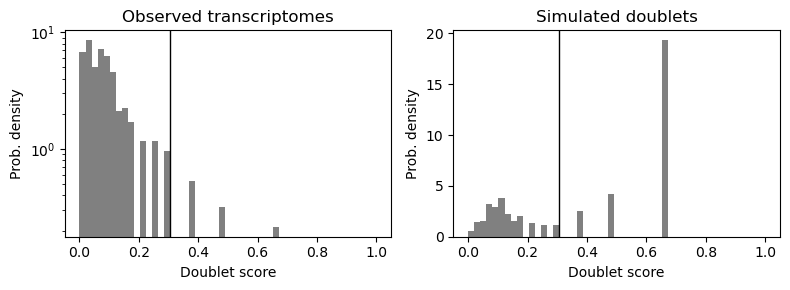

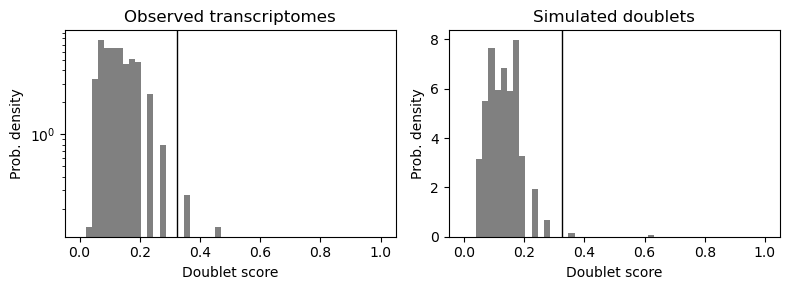

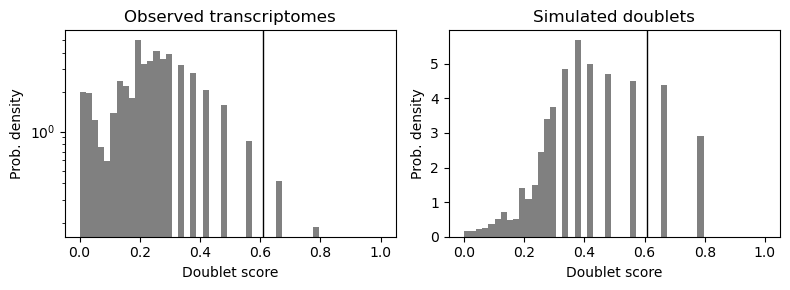

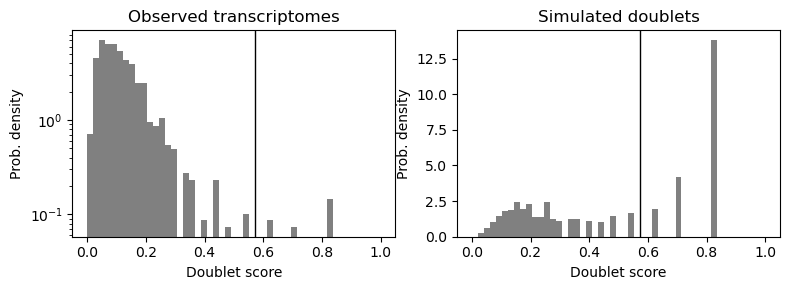

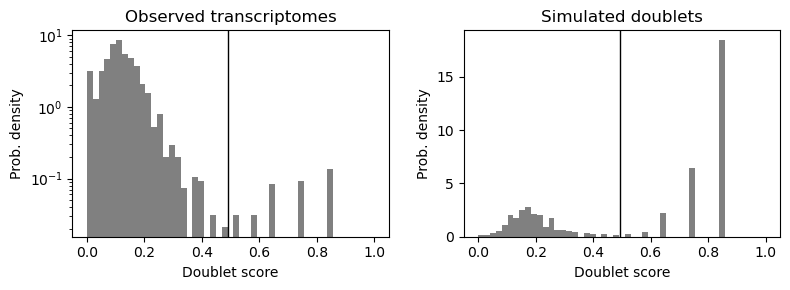

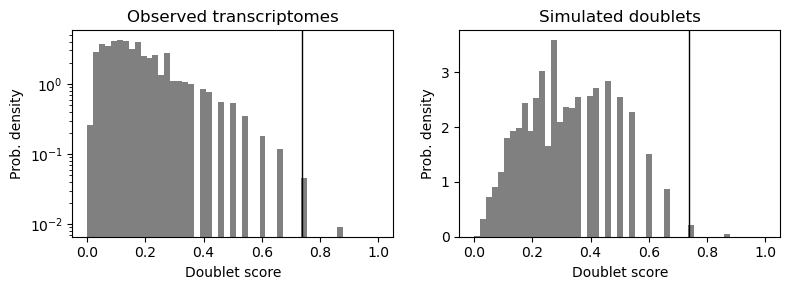

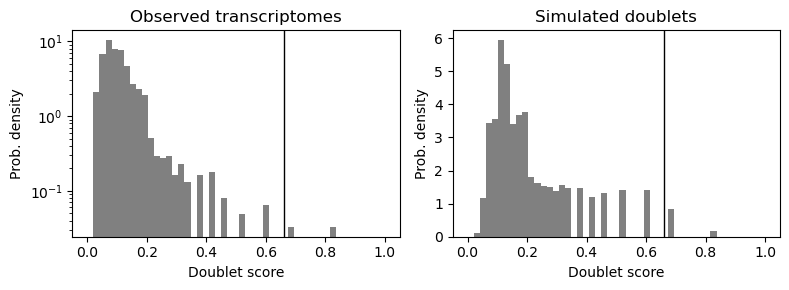

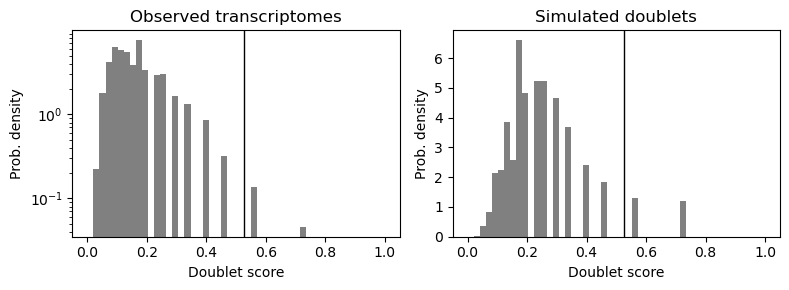

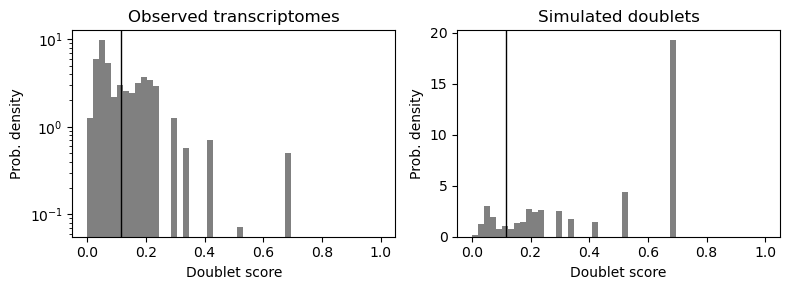

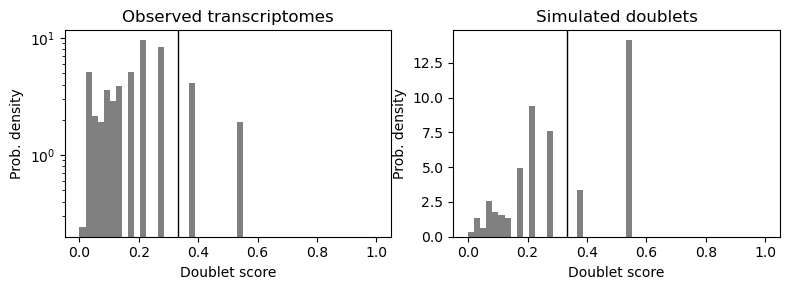

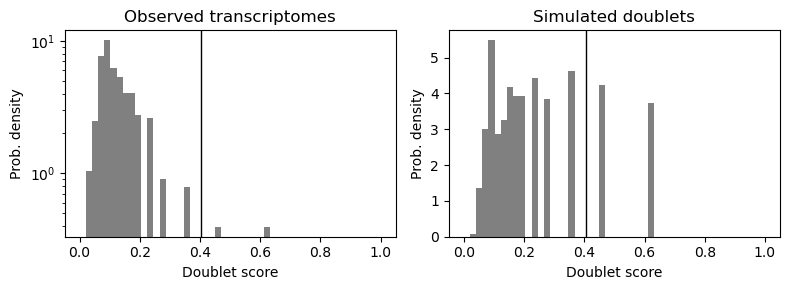

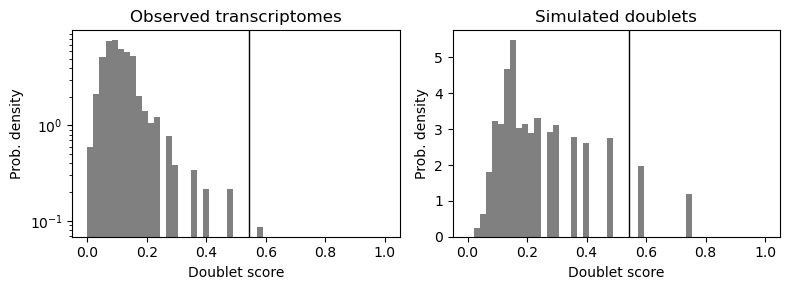

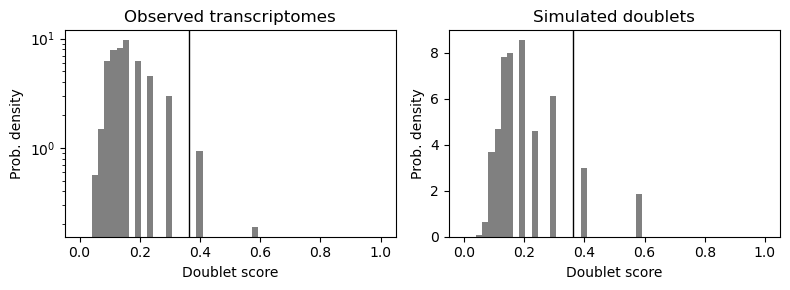

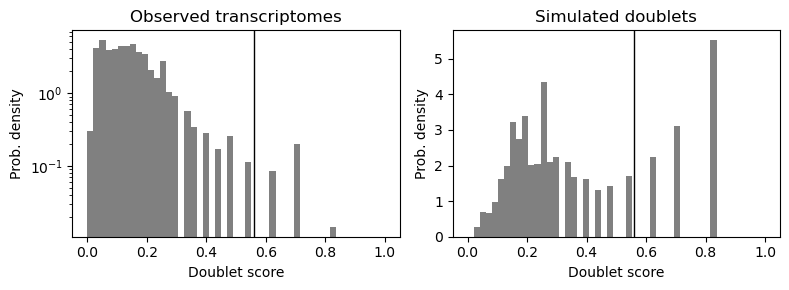

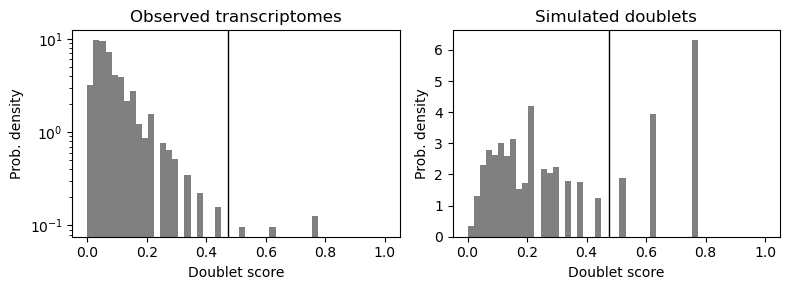

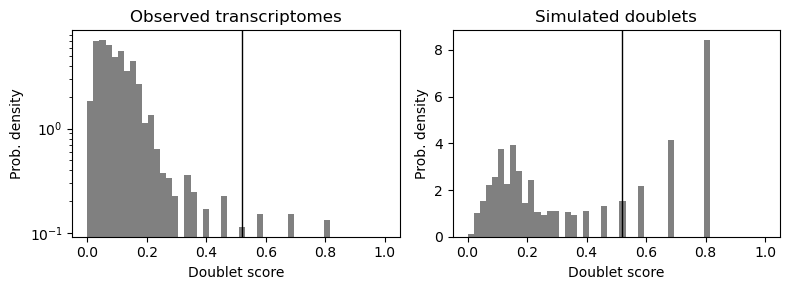

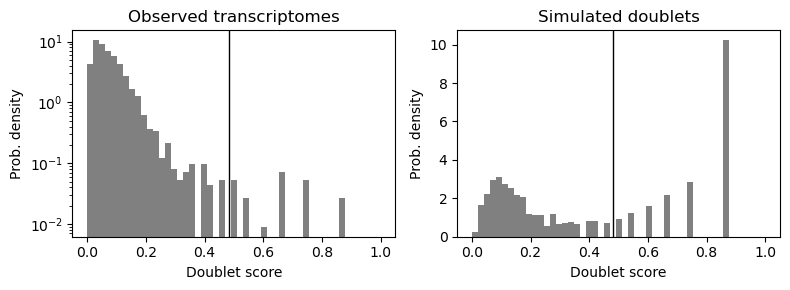

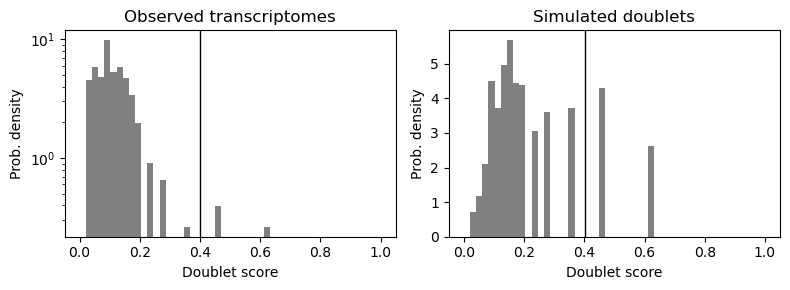

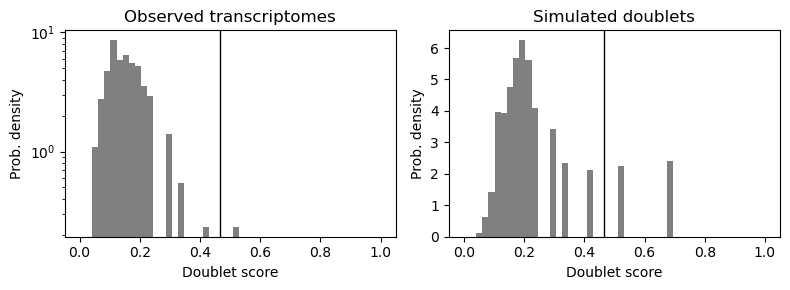

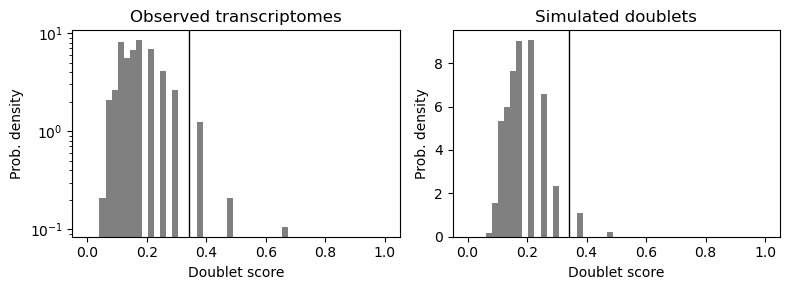

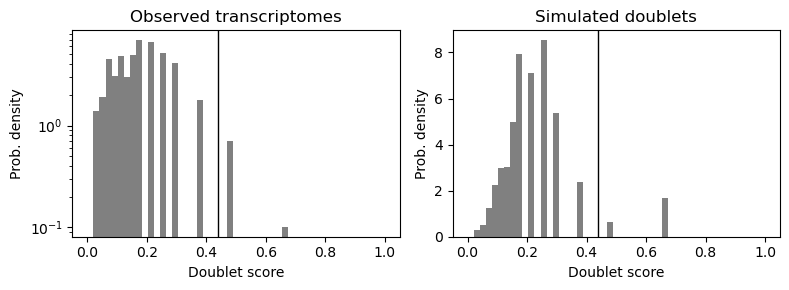

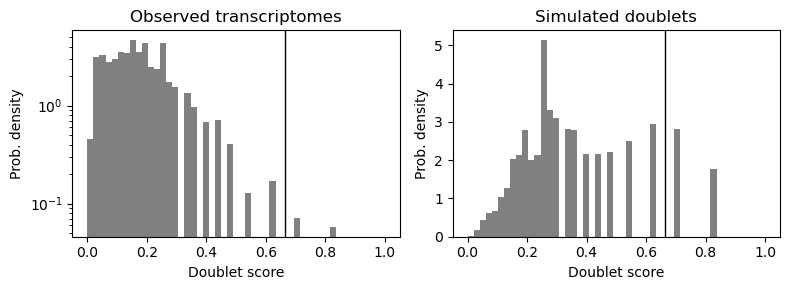

In [16]:
import scrublet as scr
for adata in adata_list:
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    
    scrub.plot_histogram()

del scrub, doublet_scores, predicted_doublets
# 3m 36s for 24 samples
# 2m 47s for 24 samples
# 1m 24.9s for Normalized, log scaled 24 samples
# Normalization 하기 전이 더 정확한가?

# Normalization and log scale the data
> Scrublet으로 doublet 제거하기 전에 하면 Pt23 샘플에서 오류남. 이유는 모르고 predicted_doublet에 None이 저장됨.

In [ ]:
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum = 1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

In [ ]:
# visualize and FILTER the doublets <- 돌려야 함.
for i in range(len(adata_list)):
    # visualize the doublets
    sc.pp.pca(adata_list[i])
    sc.pp.neighbors(adata_list[i])
    sc.tl.umap(adata_list[i])
    sc.pl.umap(adata_list[i], color=['doublet_scores', 'predicted_doublets'])
    
    # filter the doublets
    adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    
del i

# 

In [19]:
adata_list[0].obs.head()

,sample,n_genes,n_genes_by_counts,total_counts,pct_counts_mito,pct_counts_ribo,doublet_scores,predicted_doublets
AAACCCACAGAGTGAC-1,GSM5319503_SF10099_,1258,1258,2454.0,0.285249,0.529747,0.013699,False
AAAGGATCAATCGCCG-1,GSM5319503_SF10099_,1968,1968,3911.0,0.000000,0.332396,0.018868,False
AAAGGTAAGGATAATC-1,GSM5319503_SF10099_,2260,2260,4602.0,0.239027,0.173837,0.061889,False
AAAGTGAAGCGGTATG-1,GSM5319503_SF10099_,1780,1780,3002.0,0.199867,0.699534,0.035714,False
AACAACCTCAGCGTCG-1,GSM5319503_SF10099_,2587,2587,5590.0,0.751342,0.876565,0.016194,False


# Merge the data

In [17]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['GGGAGTAGTTGCTTGA-1', 'GTCGAATGTACCTAGT-1']
  warnings.warn(


# Save the merged adata

In [20]:
import re
adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1))
adata.write_h5ad(folder_path + '\\preprocessed_adata.h5ad')